In [7]:
import numpy as np
import matplotlib as mpl
import pandas as pd
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
import os
import pickle
from tqdm.auto import tqdm

mpl.rcdefaults()


## Data import

In [8]:


root_directory_base = '/auto/data6/eTheremin/'

sheet_ids = {
    "HERCULE": "1sFatSTXO0j3OONKstz7YN-mM04kNMjk_r7zo951yicU"
}

all_sessions = []

for sheet_name, sheet_id in sheet_ids.items():
    url = f"https://docs.google.com/spreadsheets/d/{sheet_id}/gviz/tq?tqx=out:csv&sheet={sheet_name}"
    df = pd.read_csv(url)

    root_directory = f'/auto/data6/eTheremin/{sheet_name}/'
    
    # Filtrer les sessions "use" == yes et type "playback"
    filtered_sessions = df[(df['use'] == 'yes')] #& (df['type'] == 'playback_block')]

    # Définir les headstages selon la règle
    headstages = [1] if sheet_name == "HERCULE" else [0, 1]

    for headstage in headstages:
        all_sessions.append({
            'sheet_name': sheet_name,
            'headstage': headstage,
            'sessions': (root_directory + filtered_sessions['session']).tolist(),
            'sessions_type': filtered_sessions['type'].tolist(),
            'timeline': filtered_sessions['timeline'].tolist()  # <-- nouvelle colonne
        })

# Exemple d'accès :
for entry in all_sessions:
    print(entry['sheet_name'], "HS", entry['headstage'], "→", len(entry['sessions'])) #, "timelines:", entry['timeline'])


HERCULE HS 1 → 21


In [9]:
all_sessions_paths = []
all_sessions_types = []

for sheet_name, sheet_id in sheet_ids.items():
    url = f"https://docs.google.com/spreadsheets/d/{sheet_id}/gviz/tq?tqx=out:csv&sheet={sheet_name}"
    df = pd.read_csv(url)

    filtered_sessions = df[(df['use'] == 'yes') & (df['type'].isin(['playback_block', 'playback']))]
    #filtered_sessions = df[(df['use'] == 'yes') & (df['type'] == 'playback')]
    #filtered_sessions = df[(df['use'] == 'yes') & (df['type'] =='playback') & (df['timeline'] =='beginner')]

    sessions = filtered_sessions['session'].tolist()
    #types = filtered_sessions['timeline'].tolist()  # récupérer les types

    # règle headstage : HERCULE => seulement 0, sinon 0 et 1
    if sheet_name == "HERCULE":
        root_directory = f'/auto/data6/eTheremin/{sheet_name}/'
        headstages = [1]

    elif sheet_name == "ALTAI":
        root_directory = f'/auto/data2/eTheremin/{sheet_name}/'
        headstages = [0, 1]
    else:
        root_directory = f'/auto/data6/eTheremin/{sheet_name}/'
        headstages = [0, 1]

    # construction des chemins avec headstage à la fin
    for s in sessions :#:zip(sessions):#, types):
        for hs in headstages:
            session_path = f"{root_directory}{s}/headstage_{hs}/"
            all_sessions_paths.append(session_path)
            #all_sessions_types.append(t)  # ajouter le type correspondant

print("Nombre total de sessions :", len(all_sessions_paths))

Nombre total de sessions : 17


In [10]:
def compare_diff(x):
    """
    Given a 1D array x, return an array y of same length with:
        y[i] =  1 if x[i] > x[i-1]
        y[i] = -1 if x[i] < x[i-1]
        y[i] =  0 if x[i] == x[i-1]
    y[0] is set to 0 by convention.
    """
    x = np.asarray(x)
    y = np.zeros_like(x, dtype=int)
    diff = np.diff(x)
    
    y[1:] = np.where(diff > 0, 1, np.where(diff < 0, -1, 0))
    
    return y

os.chdir('/auto/data6/eTheremin/')


    
files = all_sessions_paths


n_data_s = []
f_data_s = []
for file in tqdm(files) :
    try :
        n_data = np.load(file+'data_0.005.npy')
        f_data = np.load(file+'features_0.005.npy',allow_pickle=True)
        #gc = np.load(file+'good_clusters.npy')
        gc = np.arange(len(n_data))
        
        
        f_data_dict = {'Played_frequency':[],'Condition':[],'Block':[],'Frequency_changes':[],'Mock_frequency':[],'Mock_change':[]}
    
        for item in f_data:
            for key, value in item.items():
                f_data_dict[key].append(value)

        f_data = pd.DataFrame(f_data_dict)
        f_data['Change_direction'] = compare_diff(f_data['Played_frequency'].to_numpy())
        f_data['Mock_direction'] = compare_diff(f_data['Mock_frequency'].to_numpy())
        
        n_data = n_data[gc,:].astype(float)
        #n_data=n_data.astype(float)
    
        n_data_s.append(n_data)
        f_data_s.append(f_data)
        
    except :
        print('Error when building dataframe for file :' + str(file))

os.chdir('/auto/data6/eTheremin/Analysis')

  0%|          | 0/17 [00:00<?, ?it/s]

In [11]:
from scipy.ndimage import gaussian_filter
n_data_pmc_s = n_data_s
f_data_pmc_s = f_data_s
for i in tqdm(range(len(n_data_pmc_s))) :
    n_data_smooth = gaussian_filter(n_data_pmc_s[i],sigma=10,axes=1)
    n_data_pmc_s[i] = n_data_smooth

  0%|          | 0/17 [00:00<?, ?it/s]

In [12]:
num_nans = sum(np.isnan(x) for row in n_data_s for x in row if isinstance(x, float))
print(num_nans)

0


In [13]:
def moving_average(data, window_size):
    # Calculer la moyenne mobile avec remplissage
    return np.convolve(data, np.ones(window_size) / window_size, mode='same')

In [25]:
for features in f_data_pmc_s:
    print(type(features))
    
    unique_tones = np.unique(np.array(features['Played_frequency']))
    pixels = np.linspace(0, 28, len(unique_tones))        # 28 cm
    freq_to_pixel = {tone: pixel for tone, pixel in zip(unique_tones, pixels)} # tableau de correspondance des fréquences en pixels

    f_tr = features.loc[features["Condition"] == 0, "Played_frequency"].to_numpy()
    f_pb = features.loc[features["Condition"] == 1, "Mock_frequency"].to_numpy()

    f_tot = np.append(f_tr, f_pb)

    f_to_pixels = np.array([freq_to_pixel.get(f, np.nan) for f in f_tot])
    speed_x = np.diff(moving_average(f_to_pixels, window_size=50))
    speed_x = np.append(0, speed_x[0:])
    speed_x = np.abs(speed_x)
    speed_x = speed_x * 1000



    conditions_freq = [
    (features["Played_frequency"] >= 1000) & (features["Played_frequency"] < 1800),
    (features["Played_frequency"] >= 1800) & (features["Played_frequency"] < 3200),
    (features["Played_frequency"] >= 3200)
    ]
    choices = [0, 1, 2]
    features["Bin_freq"] = np.select(conditions_freq, choices, default=np.nan)

    # 🔹 Création des bins pour Mock_frequency
    conditions_mock = [
        (features["Mock_frequency"] >= 1000) & (features["Mock_frequency"] < 1800),
        (features["Mock_frequency"] >= 1800) & (features["Mock_frequency"] < 3200),
        (features["Mock_frequency"] >= 3200)
    ]
    features["Bin_mock"] = np.select(conditions_mock, choices, default=np.nan)


<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>


In [10]:
features["Bin_freq"]

0         NaN
1         NaN
2         NaN
3         NaN
4         NaN
         ... 
481431    2.0
481432    2.0
481433    2.0
481434    2.0
481435    2.0
Name: Bin_freq, Length: 481436, dtype: float64

## Analysis PMC

In [11]:
f_min, f_max = 1000, 5000


In [15]:
import numpy as np

def get_mean_psth_no_pretrigger(data, features, condition="playback", neighborhood=50, min_pre_ms=500, bin_size_ms=5):
    """
    Calcule le PSTH moyen par neurone pour tous les triggers d'une condition donnée,
    en ne gardant que les triggers pour lesquels il n'y a pas de trigger dans les `min_pre_ms` précédentes.

    Inputs:
        - data : liste ou array [n_neurones x T] contenant les taux ou vecteurs de spikes
        - features : DataFrame avec 'Frequency_changes', 'Condition', 'Played_frequency', 'Mock_change', 'Mock_frequency', etc.
        - condition : 'tracking', 'playback', 'tail', 'mapping change'
        - neighborhood : nombre de points avant et après l'événement
        - min_pre_ms : fenêtre temporelle en ms avant le trigger à vérifier
        - bin_size_ms : taille d'un bin en ms pour convertir min_pre_ms en indices

    Outputs:
        - trigger_indices : indices filtrés des événements déclencheurs
        - mean_psth : array [n_neurones x 2*neighborhood] contenant le PSTH moyen par neurone
    """

    # Mapping condition en valeur numérique
    condition_map = {"tracking": 0, "playback": 1, "tail": -1, "mapping change": 2}
    c = condition_map.get(condition, 1)

    # Sélection des triggers selon la condition
    if condition == 'tracking':
        trigger_mask = (features['Frequency_changes'] > 0) & (features['Condition'] == c)
    elif condition == 'playback':
        trigger_mask = (features['Mock_change'] > 0) & (features['Condition'] == c)
    else:
        trigger_mask = (features['Condition'] == c)

    trigger_indices = features.index[trigger_mask].to_numpy()
    trigger_indices.sort()

    # Filtrer les triggers pour ne garder que ceux qui n'ont pas de trigger dans les min_pre_ms précédentes
    min_pre_bins = int(min_pre_ms / bin_size_ms)
    filtered_indices = []
    last_kept = -np.inf
    for idx in trigger_indices:
        if idx - last_kept >= min_pre_bins:
            filtered_indices.append(idx)
            last_kept = idx
    trigger_indices = np.array(filtered_indices)

    n_neurones = len(data)
    mean_psth = np.full((n_neurones, 2 * neighborhood), np.nan)

    # Calcul du PSTH moyen par neurone
    for i, cluster_data in enumerate(data):
        cluster_segments = []
        for idx in trigger_indices:
            start = max(idx - neighborhood, 0)
            end = min(idx + neighborhood, len(cluster_data))
            segment = cluster_data[start:end]

            # Padding pour garder la taille constante 2*neighborhood
            pad_left = max(0, neighborhood - (idx - start))
            pad_right = max(0, neighborhood - (end - idx))
            segment = np.pad(segment, (pad_left, pad_right), mode='constant', constant_values=np.nan)

            cluster_segments.append(segment)

        if cluster_segments:
            mean_psth[i] = np.nanmean(cluster_segments, axis=0)

    return trigger_indices, mean_psth



In [151]:
np.unique(f_data['Change_direction'])

array([-1,  0,  1])

In [29]:
all_tracking, all_playback = [], []

for n_data, f_data in tqdm(zip(n_data_s, f_data_s), total=len(n_data_s), desc="Processing datasets"):
    
    # Centrer chaque neurone : soustraire sa moyenne
    n_data_centered = [cluster - np.nanmean(cluster) for cluster in n_data]
    
    tracking = get_mean_psth_no_pretrigger(
        n_data_centered, f_data,
        condition="tracking", neighborhood=50, min_pre_ms=2, bin_size_ms=5
    )
    playback = get_mean_psth_no_pretrigger(
        n_data_centered, f_data,
        condition="playback", neighborhood=50, min_pre_ms=2, bin_size_ms=5
    )

    all_tracking.append(tracking)
    all_playback.append(playback)


Processing datasets: 100%|██████████| 17/17 [00:37<00:00,  2.19s/it]


In [47]:
def get_mean_psth_by_direction(data, features, condition="playback", neighborhood=50, min_pre_ms=1000, bin_size_ms=5):
    """
    Calcule le PSTH moyen par neurone pour deux groupes de 'Change_direction' (0 vs -1/1),
    séparés par condition ('tracking' ou 'playback') et en ne considérant que les triggers
    où Frequency_changes == True.
    """
    # Définir les groupes Change_direction
    groups = {
        'No change': [0],
        'Change': [-1, 1]
    }
    
    # Mapping condition en valeur numérique
    condition_map = {"tracking": 0, "playback": 1, "tail": -1, "mapping change": 2}
    c_val = condition_map.get(condition, 1)

    psth_by_group = {}

    for label, dirs in groups.items():
        # Sélection des triggers correspondant à ce groupe ET à la condition
        trigger_mask = (
            features['Change_direction'].isin(dirs) &
            (features['Condition'] == c_val) &
            (features['Frequency_changes'] == True)  # <-- filtre ajouté
        )
        trigger_indices = features.index[trigger_mask].to_numpy()
        trigger_indices.sort()

        # Filtrer les triggers trop proches
        min_pre_bins = int(min_pre_ms / bin_size_ms)
        filtered_indices = []
        last_kept = -np.inf
        for idx in trigger_indices:
            if idx - last_kept >= min_pre_bins:
                filtered_indices.append(idx)
                last_kept = idx
        trigger_indices = np.array(filtered_indices)

        n_neurons = len(data)
        mean_psth = np.full((n_neurons, 2*neighborhood), np.nan)

        # Calcul PSTH moyen par neurone
        for i, cluster_data in enumerate(data):
            segments = []
            for idx in trigger_indices:
                start = max(idx - neighborhood, 0)
                end = min(idx + neighborhood, len(cluster_data))
                segment = cluster_data[start:end]
                pad_left = max(0, neighborhood - (idx - start))
                pad_right = max(0, neighborhood - (end - idx))
                segment = np.pad(segment, (pad_left, pad_right), mode='constant', constant_values=np.nan)
                segments.append(segment)
            if segments:
                mean_psth[i] = np.nanmean(segments, axis=0)

        psth_by_group[label] = mean_psth

    return psth_by_group


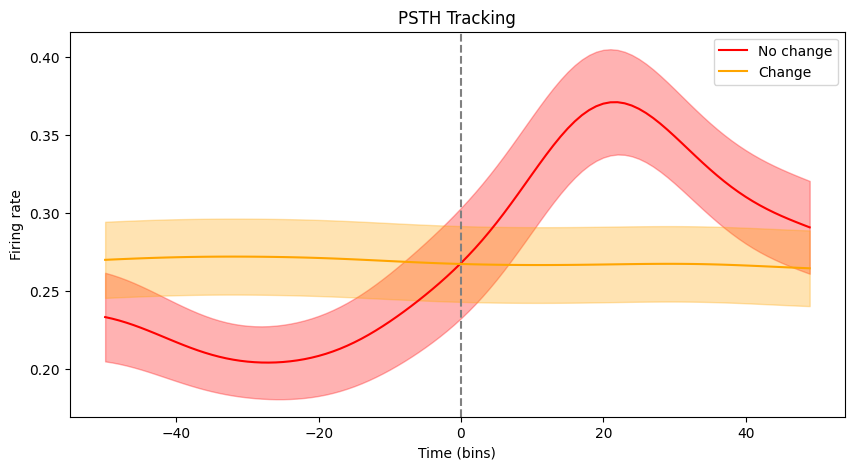

In [55]:
def get_mean_psth_by_direction_no_triggers(data, features, condition="playback", neighborhood=50, min_pre_ms=1000, bin_size_ms=5):
    """
    Calcule le PSTH moyen par neurone pour deux groupes de 'Change_direction' (0 vs -1/1),
    séparés par condition ('tracking' ou 'playback').

    Inputs:
        - data: liste [neurones x temps]
        - features: DataFrame avec 'Change_direction' et 'Condition'
        - condition: "tracking" ou "playback"
        - neighborhood, min_pre_ms, bin_size_ms: paramètres PSTH
    """
    # Définir les groupes Change_direction
    groups = {
        'No change': [0],
        'Change': [-1, 1]
    }
    
    # Mapping condition en valeur numérique
    condition_map = {"tracking": 0, "playback": 1, "tail": -1, "mapping change": 2}
    c_val = condition_map.get(condition, 1)

    psth_by_group = {}

    for label, dirs in groups.items():
        # Sélection des triggers correspondant à ce groupe ET à la condition
        trigger_mask = features['Mock_direction'].isin(dirs) & (features['Condition'] == c_val)
        trigger_indices = features.index[trigger_mask].to_numpy()
        trigger_indices.sort()

        # Filtrer les triggers trop proches
        min_pre_bins = int(min_pre_ms / bin_size_ms)
        filtered_indices = []
        last_kept = -np.inf
        for idx in trigger_indices:
            if idx - last_kept >= min_pre_bins:
                filtered_indices.append(idx)
                last_kept = idx
        trigger_indices = np.array(filtered_indices)

        n_neurons = len(data)
        mean_psth = np.full((n_neurons, 2*neighborhood), np.nan)

        # Calcul PSTH moyen par neurone
        for i, cluster_data in enumerate(data):
            segments = []
            for idx in trigger_indices:
                start = max(idx - neighborhood, 0)
                end = min(idx + neighborhood, len(cluster_data))
                segment = cluster_data[start:end]
                pad_left = max(0, neighborhood - (idx - start))
                pad_right = max(0, neighborhood - (end - idx))
                segment = np.pad(segment, (pad_left, pad_right), mode='constant', constant_values=np.nan)
                segments.append(segment)
            if segments:
                mean_psth[i] = np.nanmean(segments, axis=0)

        psth_by_group[label] = mean_psth

    return psth_by_group


# Exemple d'utilisation
psth_groups = get_mean_psth_by_direction(n_data, f_data, 'tracking', neighborhood=50, min_pre_ms=500, bin_size_ms=5)

# Calcul mean ± SEM pour chaque groupe
def compute_mean_sem_array(psth_array):
    mean = np.nanmean(psth_array, axis=0)
    sem = np.nanstd(psth_array, axis=0) / np.sqrt(psth_array.shape[0])
    return mean, sem

time = np.arange(-50, 50)

plt.figure(figsize=(10,5))
colors = {'No change':'red', 'Change':'orange'}

for label, arr in psth_groups.items():
    mean, sem = compute_mean_sem_array(arr)
    plt.fill_between(time, mean-sem, mean+sem, color=colors[label], alpha=0.3)
    plt.plot(time, mean, label=label, color=colors[label])

plt.xlabel('Time (bins)')
plt.ylabel('Firing rate')
plt.title('PSTH Tracking')
plt.axvline(0, c = 'grey', linestyle = '--')
plt.legend()
plt.show()


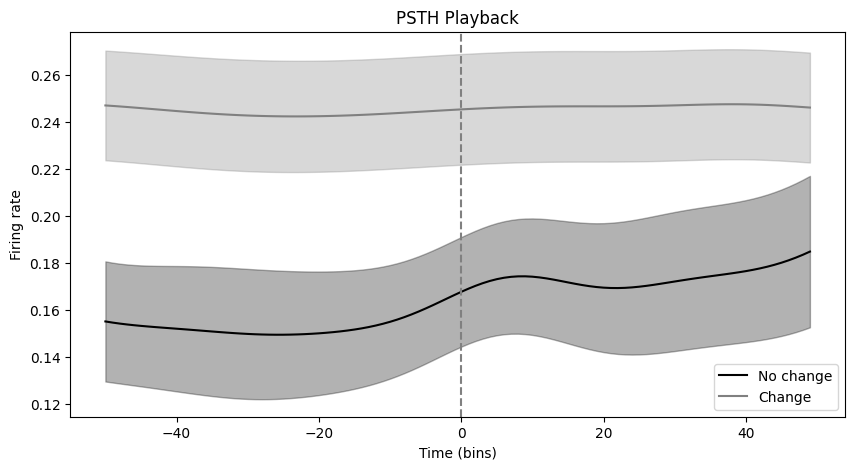

In [56]:
psth_groups = get_mean_psth_by_direction(n_data, f_data, 'playback', neighborhood=50, min_pre_ms=500, bin_size_ms=5)


plt.figure(figsize=(10,5))
colors = {'No change':'black', 'Change':'grey'}

for label, arr in psth_groups.items():
    mean, sem = compute_mean_sem_array(arr)
    plt.fill_between(time, mean-sem, mean+sem, color=colors[label], alpha=0.3)
    plt.plot(time, mean, label=label, color=colors[label])

plt.xlabel('Time (bins)')
plt.ylabel('Firing rate')
plt.title('PSTH Playback')
plt.axvline(0, c = 'grey', linestyle = '--')
plt.legend()
plt.show()


In [27]:
# directions à comparer
directions_group = {
    'No change': [0],
    'Change': [-1, 1]
}

psth_by_direction = {}
for label, dirs in directions_group.items():
    psth_by_direction[label] = get_mean_psth_by_direction(n_data, f_data, neighborhood=50, min_pre_ms=500, bin_size_ms=5, directions=dirs)

# Calcul mean ± SEM
def compute_mean_sem_array(psth_array):
    mean = np.nanmean(psth_array, axis=0)
    sem = np.nanstd(psth_array, axis=0) / np.sqrt(psth_array.shape[0])
    return mean, sem

time = np.arange(-50, 50)

plt.figure(figsize=(10, 5))
colors = {'No change':'blue', 'Change':'orange'}
for label, arr in psth_by_direction.items():
    mean, sem = compute_mean_sem_array(arr)
    plt.fill_between(time, mean-sem, mean+sem, color=colors[label], alpha=0.3)
    plt.plot(time, mean, label=label, color=colors[label])

plt.xlabel('Time (bins)')
plt.ylabel('Firing rate')
plt.title('PSTH by Change_direction')
plt.legend()
plt.show()


TypeError: unsupported operand type(s) for /: 'dict' and 'int'

<Figure size 1000x500 with 0 Axes>

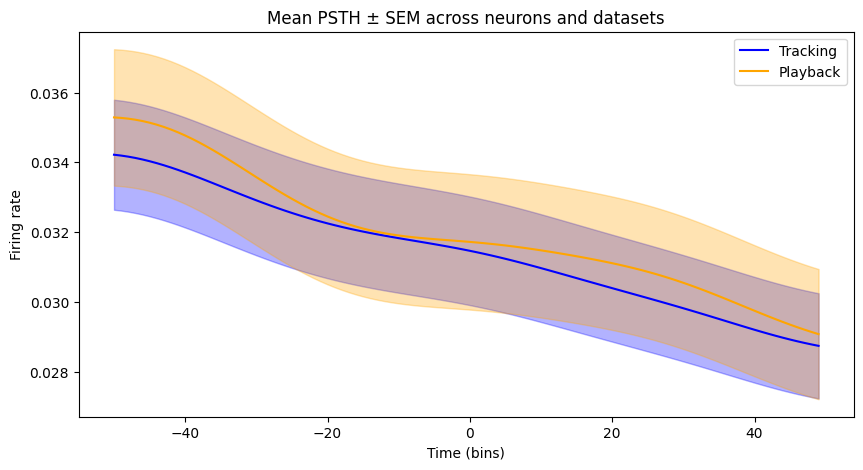

In [35]:
import numpy as np
import matplotlib.pyplot as plt

# Extraire uniquement les PSTH moyens
mean_tracking_list = [t[1] for t in all_tracking]  # t[1] = mean_psth
mean_playback_list = [t[1] for t in all_playback]

# Fonction compute_mean_sem
def compute_mean_sem(psth_list):
    psth_array = np.array(psth_list)  # shape: [datasets x neurons x 2*neighborhood]
    mean = np.nanmean(psth_array, axis=(0, 1))  # moyenne sur datasets et neurones
    sem = np.nanstd(psth_array, axis=(0, 1)) / np.sqrt(np.prod(psth_array.shape[:2]))
    return mean, sem

# Calcul mean ± SEM
mean_tracking, sem_tracking = compute_mean_sem(mean_tracking_list)
mean_playback, sem_playback = compute_mean_sem(mean_playback_list)

# Temps en bins ou convertir en ms si besoin
neighborhood = mean_tracking_list[0].shape[1] // 2  # déduit de la forme
time = np.arange(-neighborhood, neighborhood)  # centré sur l'événement

# Visualisation
plt.figure(figsize=(10, 5))
plt.fill_between(time, mean_tracking - sem_tracking, mean_tracking + sem_tracking, color='blue', alpha=0.3)
plt.plot(time, mean_tracking, label='Tracking', color='blue')

plt.fill_between(time, mean_playback - sem_playback, mean_playback + sem_playback, color='orange', alpha=0.3)
plt.plot(time, mean_playback, label='Playback', color='orange')

plt.xlabel('Time (bins)')
plt.ylabel('Firing rate')
plt.title('Mean PSTH ± SEM across neurons and datasets')
plt.legend()
plt.show()



In [ ]:
def compute_mean_sem(psth_list):
    # Convertir en array 3D si ce n'est pas déjà fait
    psth_array = np.array(psth_list)  # shape: [datasets x neurons x 2*neighborhood]
    mean = np.nanmean(psth_array, axis=(0, 1))  # moyenne sur datasets et neurones
    sem = np.nanstd(psth_array, axis=(0, 1)) / np.sqrt(np.prod(psth_array.shape[:2]))
    return mean, sem

mean_tracking, sem_tracking = compute_mean_sem(all_tracking)
mean_playback, sem_playback = compute_mean_sem(all_playback)

time = np.arange(-50, 50)  # ajuster si bins ne sont pas centrés

plt.figure(figsize=(10, 5))
plt.fill_between(time, mean_tracking - sem_tracking, mean_tracking + sem_tracking, color='blue', alpha=0.3)
plt.plot(time, mean_tracking, label='Tracking', color='blue')

plt.fill_between(time, mean_playback - sem_playback, mean_playback + sem_playback, color='orange', alpha=0.3)
plt.plot(time, mean_playback, label='Playback', color='orange')

plt.xlabel('Time (bins)')
plt.ylabel('Firing rate')
plt.title('Mean PSTH ± SEM across neurons and datasets')
plt.legend()
plt.show()


[{1111.0: array([[0.18093821, 0.17871862, 0.17653485, ..., 0.18323405, 0.18296137,
          0.18277874],
         [0.40380841, 0.40394485, 0.40400793, ..., 0.45532401, 0.45470352,
          0.45410285],
         [0.20390875, 0.20246541, 0.20071805, ..., 0.15654433, 0.15694123,
          0.15751496],
         ...,
         [0.15201312, 0.15193646, 0.15181483, ..., 0.14858878, 0.14890083,
          0.14924891],
         [0.21604537, 0.21654509, 0.21675315, ..., 0.17324982, 0.17325949,
          0.17340008],
         [0.14146914, 0.14128423, 0.14116174, ..., 0.12964111, 0.12868499,
          0.12800732]]),
  1287.0: array([[0.19694659, 0.19586648, 0.19458647, ..., 0.17965037, 0.18033606,
          0.18097091],
         [0.3669912 , 0.36610543, 0.36495957, ..., 0.38400954, 0.38528081,
          0.38653771],
         [0.1733512 , 0.17391065, 0.17429892, ..., 0.17205218, 0.17330089,
          0.17435275],
         ...,
         [0.13979958, 0.13925222, 0.13863123, ..., 0.13534838, 0.1358694

In [153]:
all_traj_pb_p_clean, all_traj_pb_m_clean, = [], []

for pb in tqdm(all_traj_pb_p, desc="Filtering NaNs"):
    # Vérifier s'il y a un NaN dans pb
    has_nan = any(np.isnan(arr).any() for arr in pb.values())
    
    if not has_nan:
        all_traj_pb_p_clean.append(pb)

for pb in tqdm(all_traj_pb_m, desc="Filtering NaNs"):
    # Vérifier s'il y a un NaN dans pb
    has_nan = any(np.isnan(arr).any() for arr in pb.values())
    
    if not has_nan:
        all_traj_pb_m_clean.append(pb)




Filtering NaNs: 100%|██████████| 12/12 [00:00<00:00, 19668.48it/s]


In [154]:
all_traj_track_p_clean, all_traj_track_m_clean = [], []

for track in tqdm(all_traj_track_p, desc="Filtering NaNs"):
    # Vérifier s'il y a un NaN dans track
    has_nan = any(np.isnan(arr).any() for arr in track.values())
    
    if not has_nan:
        all_traj_track_p_clean.append(track)

for track in tqdm(all_traj_track_m, desc="Filtering NaNs"):
    # Vérifier s'il y a un NaN dans track
    has_nan = any(np.isnan(arr).any() for arr in track.values())
    
    if not has_nan:
        all_traj_track_m_clean.append(track)


Filtering NaNs: 100%|██████████| 12/12 [00:00<00:00, 10006.29it/s]


In [155]:
all_track_p, all_track_m = [], []

for session_dict in all_traj_track_p_clean:
    # créer un nouveau dictionnaire pour cette session
    transposed_dict = {}
    for key, array in session_dict.items():
        transposed_dict[key] = array.T  # transpose le tableau
    all_track_p.append(transposed_dict)

for session_dict in all_traj_track_m_clean:
    # créer un nouveau dictionnaire pour cette session
    transposed_dict = {}
    for key, array in session_dict.items():
        transposed_dict[key] = array.T  # transpose le tableau
    all_track_m.append(transposed_dict)


In [185]:
all_track_m

[{1111.0: array([[0.14515711, 0.42909838, 0.10696327, ..., 0.13945371, 0.15516764,
          0.11240814],
         [0.14474652, 0.42740073, 0.10612212, ..., 0.13989367, 0.15535181,
          0.11137038],
         [0.14433064, 0.42556968, 0.10521873, ..., 0.14021382, 0.1554789 ,
          0.11020289],
         ...,
         [0.15357578, 0.39758977, 0.08588684, ..., 0.12715397, 0.13363118,
          0.06348957],
         [0.15526289, 0.39734316, 0.085813  , ..., 0.12739106, 0.13365737,
          0.06364452],
         [0.15689749, 0.39686693, 0.0858384 , ..., 0.12756934, 0.13371005,
          0.06398543]]),
  1287.0: array([[0.14967361, 0.42371265, 0.09120933, ..., 0.13615033, 0.15297319,
          0.11295485],
         [0.14879469, 0.42042694, 0.09091428, ..., 0.13620578, 0.15296098,
          0.11304376],
         [0.14784381, 0.41730376, 0.09067704, ..., 0.13621981, 0.15298319,
          0.1131259 ],
         ...,
         [0.1607635 , 0.44482311, 0.09145174, ..., 0.12635925, 0.1402341

In [156]:
all_pb_p, all_pb_m = [], []

for session_dict in all_traj_pb_p_clean:
    # créer un nouveau dictionnaire pour cette session
    transposed_dict = {}
    for key, array in session_dict.items():
        transposed_dict[key] = array.T  # transpose le tableau
    all_pb_p.append(transposed_dict)

for session_dict in all_traj_pb_m_clean:
    # créer un nouveau dictionnaire pour cette session
    transposed_dict = {}
    for key, array in session_dict.items():
        transposed_dict[key] = array.T  # transpose le tableau
    all_pb_m.append(transposed_dict)


In [157]:
from collections import defaultdict
def pseudo_trajectories(mean_traj_dicts):
    """
    Concatenate mean trajectories across sessions by label along the feature axis.

    Parameters:
        mean_traj_dicts (list of dict): Each dict maps label to [T, D] mean trajectory arrays.

    Returns:
        pd.DataFrame: with columns ['trajectory', 'label'].
                     'trajectory' is a [T, D_total] array for each label.
    """
    grouped_traj = defaultdict(list)

    # Group all trajectories by label
    for session_dict in mean_traj_dicts:
        for label, traj in session_dict.items():
            grouped_traj[label].append(traj)

    # Concatenate along columns (axis=1)
    data = []
    for label, traj_list in grouped_traj.items():
        concatenated = np.concatenate(traj_list, axis=1)  # shape: [T, D_total]
        data.append((concatenated, label))

    # Build the DataFrame
    df = pd.DataFrame(data, columns=["trajectory", "label"])
    return df

In [158]:
traj_df_track_p = pseudo_trajectories(all_track_p)
traj_df_track_m = pseudo_trajectories(all_track_m)

traj_df_pb_p = pseudo_trajectories(all_pb_p)
traj_df_pb_m = pseudo_trajectories(all_pb_m)


In [159]:
def check_traj_shapes(df, name=""):
    print(f"Vérification des dimensions pour {name}:")
    for i, row in df.iterrows():
        traj = row['trajectory']
        label = row['label']
        print(f"Label {label}: trajectory shape = {traj.shape}")

# Vérifier pour traj_df_track_p
check_traj_shapes(traj_df_pb_p, name="traj_df_track_p")

# Vérifier pour traj_df_track_m
check_traj_shapes(traj_df_pb_m, name="traj_df_track_m")


Vérification des dimensions pour traj_df_track_p:
Label 1111.0: trajectory shape = (100, 384)
Label 1287.0: trajectory shape = (100, 384)
Label 1490.0: trajectory shape = (100, 384)
Label 1727.0: trajectory shape = (100, 384)
Label 2000.0: trajectory shape = (100, 384)
Label 2317.0: trajectory shape = (100, 384)
Label 2684.0: trajectory shape = (100, 384)
Label 3109.0: trajectory shape = (100, 384)
Label 3601.0: trajectory shape = (100, 384)
Label 4172.0: trajectory shape = (100, 384)
Label 4832.0: trajectory shape = (100, 384)
Vérification des dimensions pour traj_df_track_m:
Label 1111.0: trajectory shape = (100, 384)
Label 1287.0: trajectory shape = (100, 384)
Label 1490.0: trajectory shape = (100, 384)
Label 1727.0: trajectory shape = (100, 384)
Label 2000.0: trajectory shape = (100, 384)
Label 2317.0: trajectory shape = (100, 384)
Label 2684.0: trajectory shape = (100, 384)
Label 3109.0: trajectory shape = (100, 384)
Label 3601.0: trajectory shape = (100, 384)
Label 4172.0: trajec

In [160]:
from sklearn.decomposition import PCA


def standardize(X):
    """Z-score standardization per feature."""
    mean = X.mean(axis=0)
    std = X.std(axis=0, ddof=0)
    std[std == 0] = 1
    return (X - mean) / std

# Stack trajectories
traj_mats = [
    np.stack(traj_df_track_p['trajectory']),
    np.stack(traj_df_track_m['trajectory']),
    np.stack(traj_df_pb_p['trajectory']),
    np.stack(traj_df_pb_m['trajectory'])
]

# Concatenate all trajectory matrices
traj_mat_all = np.concatenate(traj_mats, axis=0)

# Flatten for PCA
n_samples, n_time, n_features = traj_mat_all.shape
traj_mat_flat = standardize(traj_mat_all.reshape(n_samples * n_time, n_features))

# PCA
n_comp = 10

In [161]:
traj_mat_all.shape

(44, 100, 384)

In [162]:
pca_all = PCA(n_components=n_comp)
traj_PC_all_flat = pca_all.fit_transform(traj_mat_flat)

In [163]:
traj_PC_all = traj_PC_all_flat.reshape(n_samples, n_time, n_comp)

# Split back into groups
nb_freq = traj_mats[0].shape[0]
traj_PC_track_p, traj_PC_track_m, traj_PC_pb_p, traj_PC_pb_m= [
    traj_PC_all[i * nb_freq:(i + 1) * nb_freq] for i in range(len(traj_mats))
]

In [164]:
from mpl_toolkits.mplot3d import Axes3D 
import matplotlib.colors as mcolors
from matplotlib.colors import LinearSegmentedColormap, hsv_to_rgb
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from scipy.interpolate import splprep, splev, interp1d
from mpl_toolkits.mplot3d.art3d import Line3DCollection
from matplotlib.collections import LineCollection


def create_white_to_color_colormaps(n_colors=16):
    """
    Create a list of colormaps transitioning from white to evenly spaced colors on the HSV wheel.

    Parameters:
        n_colors (int): Number of distinct colormaps to generate.

    Returns:
        list of LinearSegmentedColormap: List of custom colormaps.
    """
    colormaps = []
    for i in range(n_colors):
        hue = i / n_colors  # evenly spaced hue
        color = mcolors.hsv_to_rgb([hue, 1.0, 1.0])  # pure hue at full saturation/value
        cmap = mcolors.LinearSegmentedColormap.from_list(
            f'white_to_color_{i}', [(1, 1, 1), color], N=256
        )
        colormaps.append(cmap)
    return colormaps
    
def get_hsv_colors(n_colors=16):
    """Generate evenly spaced HSV colors converted to RGB."""
    return [mcolors.hsv_to_rgb([i / n_colors, 1.0, 1.0]) for i in range(n_colors)]

def add_phase_gradient_legend(ax, colors, tick_labels=None, vertical=False):
    """
    Draws a phase gradient legend on an existing axis.

    Parameters:
        ax (matplotlib.axes.Axes): Axis on which to draw the gradient.
        colors (list): List of RGB colors defining the gradient.
        tick_labels (list): Optional list of tick labels (must match len(colors)).
        vertical (bool): If True, draw vertically instead of horizontally.
    """
    n = len(colors)
    steps = 32  # Resolution per segment for smoothness
    cmap = mcolors.LinearSegmentedColormap.from_list("phase_gradient", colors)

    if vertical:
        gradient = np.linspace(0, 1, n * steps).reshape(-1, 1)
        ax.imshow(gradient, aspect='auto', cmap=cmap, origin='lower')
        ax.set_xticks([])
        tick_positions = np.linspace(0, gradient.shape[0] - 1, n)
        ax.set_yticks(tick_positions)
        if tick_labels:
            ax.set_yticklabels(tick_labels)
        else:
            ax.set_yticklabels([f"{i}" for i in range(n)])
    else:
        gradient = np.linspace(0, 1, n * steps).reshape(1, -1)
        ax.imshow(gradient, aspect='auto', cmap=cmap)
        ax.set_yticks([])
        tick_positions = np.linspace(0, gradient.shape[1] - 1, n)
        ax.set_xticks(tick_positions)
        if len(tick_labels)>0:
            ax.set_xticklabels(tick_labels, rotation=45, ha='right')
        else:
            ax.set_xticklabels([f"{i}" for i in range(n)])
    
    ax.tick_params(axis='both', length=0)

def add_inset_phase_legend(main_ax, colors, tick_labels=None, location='upper right', size="30%", pad=0.05):
    """
    Adds a compact phase gradient legend to an existing axis using an inset.

    Parameters:
        main_ax (matplotlib.axes.Axes): The main axis to attach the legend to.
        colors (list): List of RGB colors defining the gradient.
        tick_labels (list): List of tick labels for each color.
        location (str): Location inside main_ax to place the inset ('lower right', 'upper left', etc.).
        size (str or tuple): Size of the inset axes, e.g., '30%' or (width, height).
        pad (float): Padding from edge of the main_ax.
    """
    n = len(colors)
    steps = 32
    gradient = np.linspace(0, 1, n * steps).reshape(1, -1)
    cmap = LinearSegmentedColormap.from_list("phase_gradient", colors)

    # Create inset axis
    inset_ax = inset_axes(main_ax, width=size, height="5%", loc=location, borderpad=pad)
    inset_ax.imshow(gradient, aspect='auto', cmap=cmap)
    inset_ax.set_yticks([])

    tick_positions = np.linspace(0, gradient.shape[1] - 1, n)
    inset_ax.set_xticks(tick_positions)

    if len(tick_labels)>0:
        inset_ax.set_xticklabels(tick_labels, rotation=45, ha='right',fontsize=12)
        inset_ax.set_title('Frequency change',fontsize=15)
    else:
        inset_ax.set_xticklabels([str(i) for i in range(n)])

    inset_ax.tick_params(axis='x', length=0)
    
def draw_traj(traj,ax,cmap,three_d=False) :
    t_length=len(traj)
    for i in range(t_length-1):
        color = cmap(0.1+0.9*i / (t_length - 1))
        if three_d :
            ax.plot(traj[i:i+2,0],traj[i:i+2,1],traj[i:i+2,2],color=color,linewidth=5)
        else :
            ax.plot(traj[i:i+2,0],traj[i:i+2,1],color=color,linewidth=4)


def plot_gradient_curve(points, base_colors, ax, n_interp=200, smooth=0, marker='o', lw=2, alpha=0.8, show_plane=False,plane_color='grey', plane_alpha=0.1):
    """
    Fit a smooth curve through points (2D or 3D) and color it using HSV/RGB base colors.
    Optionally show the 2D PCA plane of maximum variance in 3D case.
    """
    points = np.asarray(points)
    base_colors = np.asarray(base_colors)
    N, dim = points.shape
    if dim not in (2, 3):
        raise ValueError("Points must be either 2D or 3D.")

    # Parameterize the spline by normalized arc length
    distances = np.linalg.norm(np.diff(points, axis=0), axis=1)
    cumulative_dist = np.insert(np.cumsum(distances), 0, 0)
    cumulative_dist /= cumulative_dist[-1] if cumulative_dist[-1] != 0 else 1.0

    # Fit spline
    tck, u = splprep(points.T, s=smooth, k=min(3, N-1))
    u_interp = np.linspace(0, 1, n_interp)
    coords_interp = splev(u_interp, tck)
    curve_points = np.stack(coords_interp, axis=1)

    # Interpolate colors
    interp_r = interp1d(u, base_colors[:, 0], kind='linear', fill_value="extrapolate")
    interp_g = interp1d(u, base_colors[:, 1], kind='linear', fill_value="extrapolate")
    interp_b = interp1d(u, base_colors[:, 2], kind='linear', fill_value="extrapolate")
    rgb_interp = np.stack([interp_r(u_interp), interp_g(u_interp), interp_b(u_interp)], axis=1)

    # Build segments for gradient
    segments = np.stack([curve_points[:-1], curve_points[1:]], axis=1)
    segment_colors = rgb_interp[:-1]

    if dim == 2:
        lc = LineCollection(segments, colors=segment_colors, linewidths=lw, alpha=alpha)
        ax.add_collection(lc)
        ax.scatter(points[:, 0], points[:, 1], c=base_colors, edgecolor='k', marker=marker, s=40, zorder=3)

    else:
        lc = Line3DCollection(segments, colors=segment_colors, linewidths=lw, alpha=alpha)
        ax.add_collection3d(lc)
        ax.scatter(points[:, 0], points[:, 1], points[:, 2],
                   c=base_colors, edgecolor='k', marker=marker, s=40, zorder=3)

        # Optionally draw 2D PCA plane
        if show_plane:
            pca = PCA(n_components=2)
            pca.fit(points)
            center = points.mean(axis=0)
            vecs = pca.components_
            # Create grid in PCA space
            grid_range = np.linspace(-1, 1, 10) * np.std(points, axis=0).max()
            Xg, Yg = np.meshgrid(grid_range, grid_range)
            plane_points = center + Xg[..., None] * vecs[0] + Yg[..., None] * vecs[1]
            ax.plot_surface(plane_points[..., 0], plane_points[..., 1], plane_points[..., 2],
                            color=plane_color, alpha=plane_alpha, linewidth=0, shade=False)


        return pca.components_

100


Text(0.5, 1.0, 'Tracking & playback')

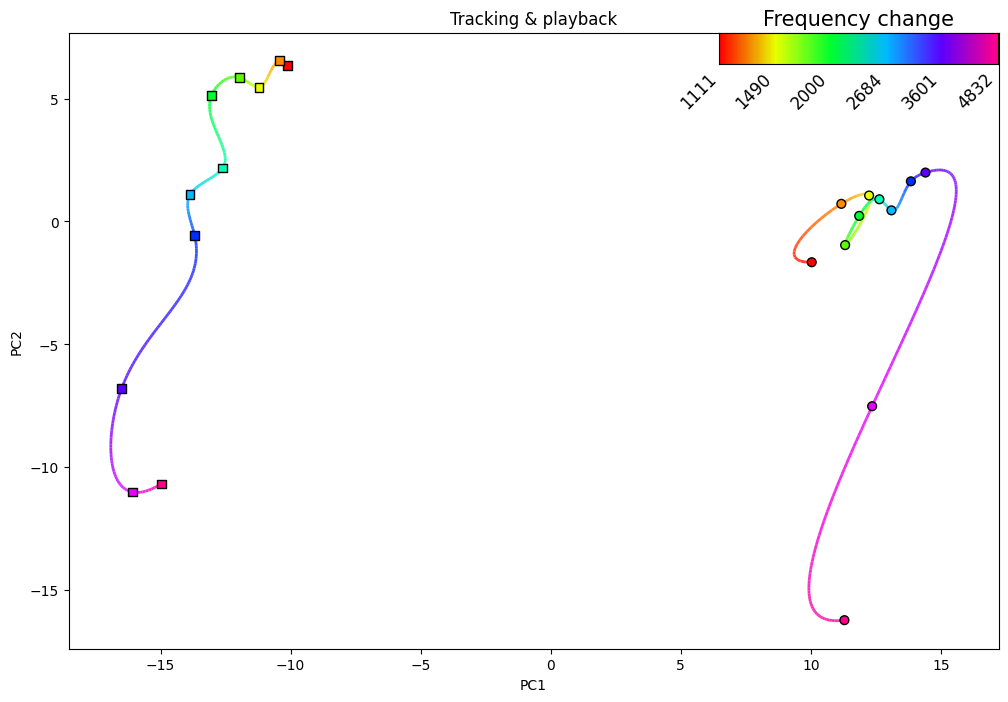

In [165]:
cmaps = create_white_to_color_colormaps(n_colors=16)

fig=plt.figure(figsize=(12,8))
#ax = fig.add_subplot(111, projection='3d')
ax = fig.add_subplot(111)

traj_toplot = traj_PC_track_p

nb_times = len(traj_toplot[0])
print(nb_times)

start_time = int(nb_times*0.3)
stop_time = int(nb_times*0.7)


    
colors = get_hsv_colors(len(traj_toplot))
comp = [0,1]


#ax.scatter(traj_PC_pb[:,-1,1],traj_PC_pb[:,-1,2],c=colors,s=100)
add_inset_phase_legend(ax, colors[::2],tick_labels=traj_df_track_p['label'].to_numpy().astype(int)[::2])
plot_gradient_curve(traj_PC_track_p[:,stop_time,comp],colors, ax)
plot_gradient_curve(traj_PC_pb_m[:,stop_time,comp],colors, ax, marker = 's')

ax.set_xlabel('PC'+ str(comp[0]+1))
ax.set_ylabel('PC'+ str(comp[1]+1))

ax.set_title('Tracking & playback')

In [175]:
from sklearn.decomposition import PCA

R =  traj_mat_flat
n_comp = 10  # nombre de composantes que tu veux garder
pca = PCA(n_components=n_comp)
pca.fit(R)  # R : [time_concat_conditions × neurons]

w_pc1 = pca.components_[0]  # premier vecteur de poids (PC1)
# shape = [neurons]



In [180]:

n_trials, n_time, n_neurons = all_pb_m.shape
z_trials = np.zeros((n_trials, n_time))

for i in range(n_trials):
    z_trials[i] = all_pb_m[i] @ w_pc1  # projection du trial i sur PC1

AttributeError: 'list' object has no attribute 'shape'

In [176]:

from dPCA import dPCA

dpca = dPCA(labels='ci', n_components=10)  # 'ci' pour condition-invariant
dpca.fit(R)  # R : [time_concat_conditions × neurons]

w_cis1 = dpca.components_['ci'][0]  # première dimension CI
# shape = [neurons]


ModuleNotFoundError: No module named 'dPCA'

In [167]:
n_samples, n_time, n_comp = traj_PC_all.shape

# On projette chaque trial sur PC1
z_trials = np.zeros((n_samples, n_time))

for i in range(n_samples):
    # produit scalaire entre les features et PC1
    z_trials[i] = traj_mat_all[i] @ w_pc1  # shape = (n_time,)


In [168]:
# Critère basé sur les trials long-delay (ici tous les trials de traj_PC_all)
z_median = np.mean(z_trials, axis=0)  # médiane sur les trials
criterion = (np.max(z_median) + np.min(z_median)) / 2


In [169]:
crossing_times = np.full(n_samples, np.nan)

for i in range(n_samples):
    post_go = z_trials[i, go_cue_idx:]
    above = np.where(post_go >= criterion)[0]
    if len(above) > 0:
        crossing_times[i] = above[0] + go_cue_idx  # temps relatif au go cue


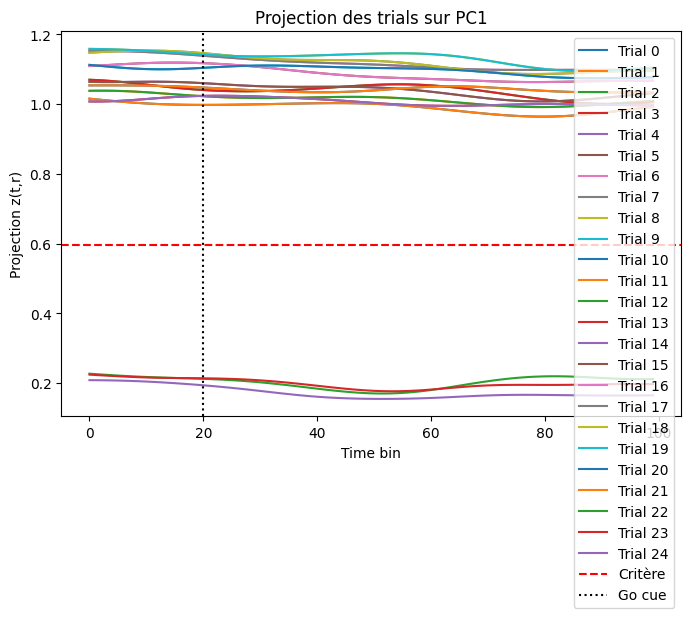

In [170]:
import matplotlib.pyplot as plt

# Afficher les premières trials
plt.figure(figsize=(8,5))
for i in range(25):
    plt.plot(z_trials[i], label=f'Trial {i}')
plt.axhline(criterion, color='r', linestyle='--', label='Critère')
plt.axvline(go_cue_idx, color='k', linestyle=':', label='Go cue')
plt.xlabel('Time bin')
plt.ylabel('Projection z(t,r)')
plt.title('Projection des trials sur PC1')
plt.legend()
plt.show()


In [174]:
len(z_trials)

44

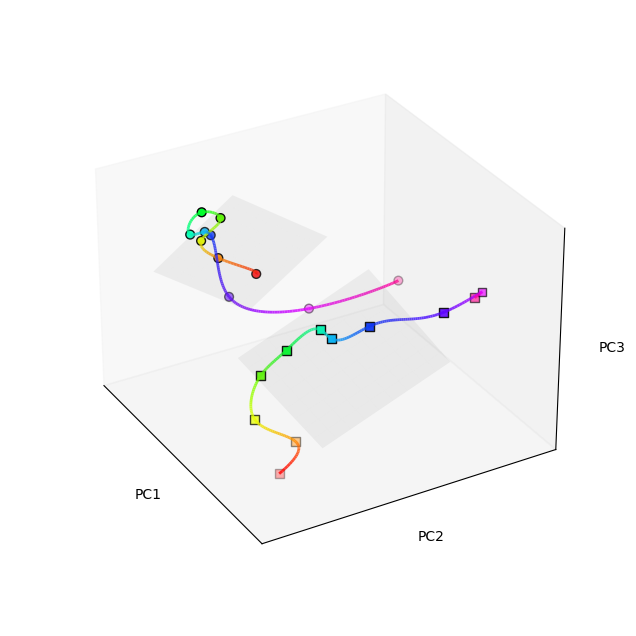

In [171]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
%matplotlib inline


def plot_plane(ax, B, center=None, size=1.0, alpha=0.2, color='cyan'):
    B = np.asarray(B)
    if B.shape != (3, 2):
        raise ValueError("B must be shape (3, 2) — two 3D spanning vectors.")

    if center is None:
        center = np.zeros(3)
    else:
        center = np.asarray(center)
    
    # Define corners of the plane
    v1, v2 = B[:, 0] * size, B[:, 1] * size
    corners = np.array([
        center - v1 - v2,
        center + v1 - v2,
        center + v1 + v2,
        center - v1 + v2
    ])

    # Create the polygon
    poly = Poly3DCollection([corners], alpha=alpha, facecolor=color, edgecolor='none')
    ax.add_collection3d(poly)


cmaps = create_white_to_color_colormaps(n_colors=16)

fig=plt.figure(figsize=(12,8))
ax = fig.add_subplot(111, projection='3d')
colors = get_hsv_colors(len(traj_df_track_m))


comps=[0,1,2]

#ax.scatter(traj_PC_track[:,-1,0],traj_PC_track[:,stop_time,1],traj_PC_track[:,stop_time,2],c=colors,s=100)
#ax.scatter(traj_PC_pb[:,-1,0],traj_PC_pb[:,stop_time,1],traj_PC_pb[:,stop_time,2],c=colors,s=100)
#plane_track = plot_gradient_curve(traj_PC_track[:,10,comps],colors, ax,show_plane=True)
#plane_pb = plot_gradient_curve(traj_PC_pb[:,10,comps],colors, ax,marker='s',show_plane=True)

plane_0 = plot_gradient_curve(traj_PC_track_m[:,10,comps],colors, ax,show_plane=True)

plane_1 = plot_gradient_curve(traj_PC_pb_m[:,10,comps],colors, ax,marker='s',show_plane=True)




ax.set_xlabel('PC'+ str(comps[0]+1))
ax.set_ylabel('PC'+ str(comps[1]+1))
ax.set_zlabel('PC'+ str(comps[2]+1))
ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])
ax.set_box_aspect(None, zoom=0.85)
ax.view_init(azim=150, elev=30)
#plt.savefig('Plots/SVG/tonotopy_comparison_hstage1.svg', dpi = 300,bbox_inches='tight')
#plt.savefig('Plots/PNG/tonotopy_comparison_hstage1.png', dpi = 300,bbox_inches='tight')

In [172]:
# donc on a recuperé les PC

NameError: name 'traj_df_track_0' is not defined

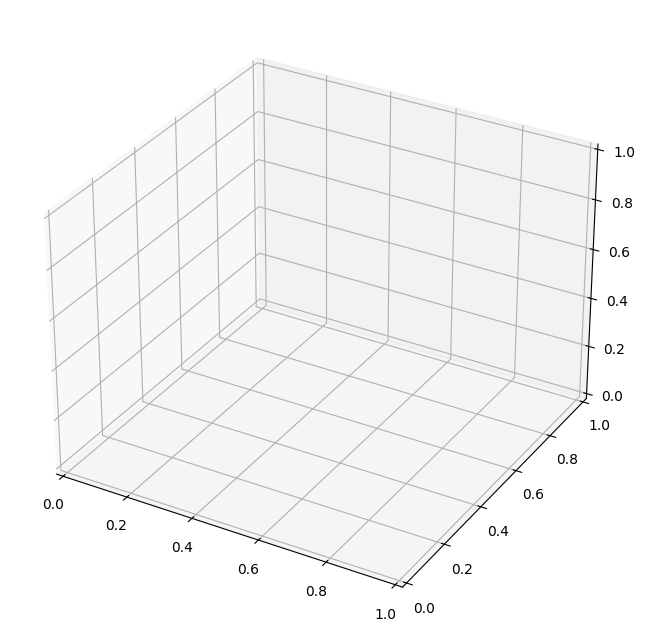

In [173]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
%matplotlib inline


def plot_plane(ax, B, center=None, size=1.0, alpha=0.2, color='cyan'):
    B = np.asarray(B)
    if B.shape != (3, 2):
        raise ValueError("B must be shape (3, 2) — two 3D spanning vectors.")

    if center is None:
        center = np.zeros(3)
    else:
        center = np.asarray(center)
    
    # Define corners of the plane
    v1, v2 = B[:, 0] * size, B[:, 1] * size
    corners = np.array([
        center - v1 - v2,
        center + v1 - v2,
        center + v1 + v2,
        center - v1 + v2
    ])

    # Create the polygon
    poly = Poly3DCollection([corners], alpha=alpha, facecolor=color, edgecolor='none')
    ax.add_collection3d(poly)


cmaps = create_white_to_color_colormaps(n_colors=16)

fig=plt.figure(figsize=(12,8))
ax = fig.add_subplot(111, projection='3d')
colors = get_hsv_colors(len(traj_df_track_0))


comps=[0,1,2]

#ax.scatter(traj_PC_track[:,-1,0],traj_PC_track[:,stop_time,1],traj_PC_track[:,stop_time,2],c=colors,s=100)
#ax.scatter(traj_PC_pb[:,-1,0],traj_PC_pb[:,stop_time,1],traj_PC_pb[:,stop_time,2],c=colors,s=100)
#plane_track = plot_gradient_curve(traj_PC_track[:,10,comps],colors, ax,show_plane=True)
#plane_pb = plot_gradient_curve(traj_PC_pb[:,10,comps],colors, ax,marker='s',show_plane=True)

plane_0 = plot_gradient_curve(traj_PC_track_0[:,10,comps],colors, ax,show_plane=True)

plane_1 = plot_gradient_curve(traj_PC_pb_0[:,10,comps],colors, ax,marker='s',show_plane=True)




ax.set_xlabel('PC'+ str(comps[0]+1))
ax.set_ylabel('PC'+ str(comps[1]+1))
ax.set_zlabel('PC'+ str(comps[2]+1))
ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])
ax.set_box_aspect(None, zoom=0.85)
ax.view_init(azim=160, elev=30)
ax.view_init(azim=50, elev=10)
from matplotlib.lines import Line2D

# Définition de la légende
legend_elements = [
    Line2D([0], [0], marker='o', color='w', label='Tracking',
           markerfacecolor='gray', markersize=10),  # rond
    Line2D([0], [0], marker='s', color='w', label='Playback',
           markerfacecolor='gray', markersize=10)   # carré
]

ax.legend(handles=legend_elements, loc='upper right', fontsize=12)
#plt.savefig('Plots/SVG/tonotopy_comparison_hstage1.svg', dpi = 300,bbox_inches='tight')
#plt.savefig('Plots/PNG/tonotopy_comparison_hstage1.png', dpi = 300,bbox_inches='tight')

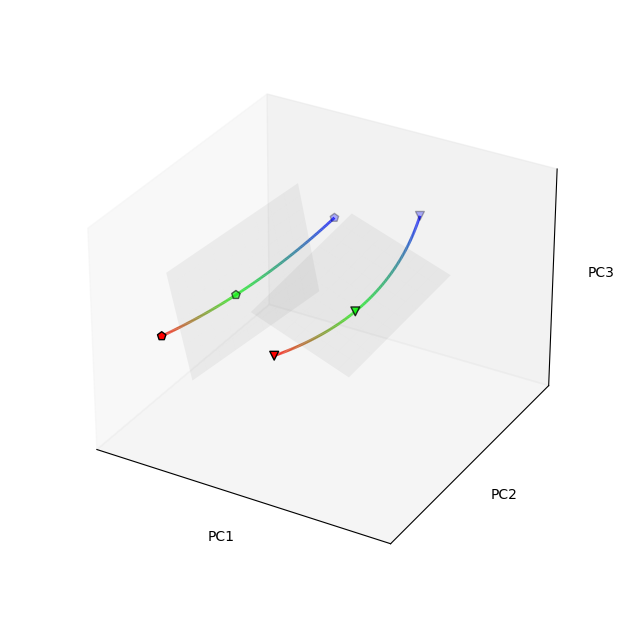

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
%matplotlib inline


def plot_plane(ax, B, center=None, size=1.0, alpha=0.2, color='cyan'):
    B = np.asarray(B)
    if B.shape != (3, 2):
        raise ValueError("B must be shape (3, 2) — two 3D spanning vectors.")

    if center is None:
        center = np.zeros(3)
    else:
        center = np.asarray(center)
    
    # Define corners of the plane
    v1, v2 = B[:, 0] * size, B[:, 1] * size
    corners = np.array([
        center - v1 - v2,
        center + v1 - v2,
        center + v1 + v2,
        center - v1 + v2
    ])

    # Create the polygon
    poly = Poly3DCollection([corners], alpha=alpha, facecolor=color, edgecolor='none')
    ax.add_collection3d(poly)


cmaps = create_white_to_color_colormaps(n_colors=16)

fig=plt.figure(figsize=(12,8))
ax = fig.add_subplot(111, projection='3d')
colors = get_hsv_colors(len(traj_df_track_0))


comps=[0,1,2]

#ax.scatter(traj_PC_track[:,-1,0],traj_PC_track[:,stop_time,1],traj_PC_track[:,stop_time,2],c=colors,s=100)
#ax.scatter(traj_PC_pb[:,-1,0],traj_PC_pb[:,stop_time,1],traj_PC_pb[:,stop_time,2],c=colors,s=100)
#plane_track = plot_gradient_curve(traj_PC_track[:,10,comps],colors, ax,show_plane=True)
#plane_pb = plot_gradient_curve(traj_PC_pb[:,10,comps],colors, ax,marker='s',show_plane=True)



#plane_0 = plot_gradient_curve(traj_PC_track_0[:,10,comps],colors, ax,show_plane=True)

#plane_1 = plot_gradient_curve(traj_PC_track_1[:,10,comps],colors, ax,marker='s',show_plane=True)

plane_2 = plot_gradient_curve(traj_PC_track_2[:,10,comps],colors, ax,marker='p',show_plane=True)

#plane_0 = plot_gradient_curve(traj_PC_pb_0[:,10,comps],colors, ax, marker = 'x',show_plane=True)

#plane_1 = plot_gradient_curve(traj_PC_pb_1[:,10,comps],colors, ax,marker='^',show_plane=True)

plane_2 = plot_gradient_curve(traj_PC_pb_2[:,10,comps],colors, ax,marker='v',show_plane=True)

#plot_plane(ax, cca_a1[comps,:][:,[0,1]], size=20, alpha=0.1, color='cyan')


ax.set_xlabel('PC'+ str(comps[0]+1))
ax.set_ylabel('PC'+ str(comps[1]+1))
ax.set_zlabel('PC'+ str(comps[2]+1))
ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])
ax.set_box_aspect(None, zoom=0.85)
ax.view_init(azim=120, elev=30)
#plt.savefig('Plots/SVG/tonotopy_comparison_hstage1.svg', dpi = 300,bbox_inches='tight')
#plt.savefig('Plots/PNG/tonotopy_comparison_hstage1.png', dpi = 300,bbox_inches='tight')

In [ ]:
def pseudo_trajectories(mean_traj_dicts):
    """
    Concatenate mean trajectories across sessions by label along the feature axis.

    Parameters:
        mean_traj_dicts (list of dict): Each dict maps label to [T, D] mean trajectory arrays.

    Returns:
        pd.DataFrame: with columns ['trajectory', 'label'].
                     'trajectory' is a [T, D_total] array for each label.
    """
    grouped_traj = {key:[] for key in mean_traj_dicts[0].keys()}

    # Group all trajectories by label
    for session_dict in mean_traj_dicts:
        for label, traj in session_dict.items():
            grouped_traj[label].append(traj)

    # Concatenate along columns (axis=1)
    data = []
    for label, traj_list in grouped_traj.items():
        concatenated = np.concatenate(traj_list, axis=1)  # shape: [T, D_total]
        data.append((concatenated, label))

    # Build the DataFrame
    df = pd.DataFrame(data, columns=["trajectory", "label"])
    return df


traj_df_track_p, traj_df_track_m = pseudo_trajectories(all_traj_track_p), pseudo_trajectories(all_traj_track_m)
traj_df_pb_p, traj_df_pb_m = pseudo_trajectories(all_traj_pb_p), pseudo_trajectories(all_traj_pb_m)

NameError: name 'all_traj_track_p' is not defined

In [ ]:
from sklearn.decomposition import PCA
import numpy as np

def standardize(X):
    """Z-score standardization per feature."""
    mean = X.mean(axis=0)
    std = X.std(axis=0, ddof=0)
    std[std == 0] = 1
    return (X - mean) / std

# Stack and combine trajectory matrices
traj_mats = [
    np.stack(traj_df_track_p['trajectory']),
    np.stack(traj_df_track_m['trajectory']),
    np.stack(traj_df_pb_p['trajectory']),
    np.stack(traj_df_pb_m['trajectory']),
    # np.stack(traj_df_pb_mock['trajectory'])  # optional
]
traj_mat_all = np.concatenate(traj_mats, axis=0)

# Flatten for PCA
n_trials, n_time, n_features = traj_mat_all.shape
traj_mat_flat = standardize(traj_mat_all.reshape(n_trials * n_time, n_features))

# PCA
n_comp = 10
pca_all = PCA(n_components=n_comp)
traj_PC_all_flat = pca_all.fit_transform(traj_mat_flat)

# Reshape back to (trial, time, components)
traj_PC_all = traj_PC_all_flat.reshape(n_trials, n_time, n_comp)

# Split results back into groups
nb_freq = traj_mats[0].shape[0]
traj_PC_track_p, traj_PC_track_m, traj_PC_pb_p, traj_PC_pb_m = [
    traj_PC_all[i * nb_freq:(i + 1) * nb_freq] for i in range(len(traj_mats))
]



### Visualization

In [ ]:
from mpl_toolkits.mplot3d import Axes3D 
import matplotlib.colors as mcolors
from matplotlib.colors import LinearSegmentedColormap, hsv_to_rgb
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from scipy.interpolate import splprep, splev, interp1d
from mpl_toolkits.mplot3d.art3d import Line3DCollection
from matplotlib.collections import LineCollection


def create_white_to_color_colormaps(n_colors=16):
    """
    Create a list of colormaps transitioning from white to evenly spaced colors on the HSV wheel.

    Parameters:
        n_colors (int): Number of distinct colormaps to generate.

    Returns:
        list of LinearSegmentedColormap: List of custom colormaps.
    """
    colormaps = []
    for i in range(n_colors):
        hue = i / n_colors  # evenly spaced hue
        color = mcolors.hsv_to_rgb([hue, 1.0, 1.0])  # pure hue at full saturation/value
        cmap = mcolors.LinearSegmentedColormap.from_list(
            f'white_to_color_{i}', [(1, 1, 1), color], N=256
        )
        colormaps.append(cmap)
    return colormaps
    
def get_hsv_colors(n_colors=16):
    """Generate evenly spaced HSV colors converted to RGB."""
    return [mcolors.hsv_to_rgb([i / n_colors, 1.0, 1.0]) for i in range(n_colors)]

def add_phase_gradient_legend(ax, colors, tick_labels=None, vertical=False):
    """
    Draws a phase gradient legend on an existing axis.

    Parameters:
        ax (matplotlib.axes.Axes): Axis on which to draw the gradient.
        colors (list): List of RGB colors defining the gradient.
        tick_labels (list): Optional list of tick labels (must match len(colors)).
        vertical (bool): If True, draw vertically instead of horizontally.
    """
    n = len(colors)
    steps = 32  # Resolution per segment for smoothness
    cmap = mcolors.LinearSegmentedColormap.from_list("phase_gradient", colors)

    if vertical:
        gradient = np.linspace(0, 1, n * steps).reshape(-1, 1)
        ax.imshow(gradient, aspect='auto', cmap=cmap, origin='lower')
        ax.set_xticks([])
        tick_positions = np.linspace(0, gradient.shape[0] - 1, n)
        ax.set_yticks(tick_positions)
        if tick_labels:
            ax.set_yticklabels(tick_labels)
        else:
            ax.set_yticklabels([f"{i}" for i in range(n)])
    else:
        gradient = np.linspace(0, 1, n * steps).reshape(1, -1)
        ax.imshow(gradient, aspect='auto', cmap=cmap)
        ax.set_yticks([])
        tick_positions = np.linspace(0, gradient.shape[1] - 1, n)
        ax.set_xticks(tick_positions)
        if len(tick_labels)>0:
            ax.set_xticklabels(tick_labels, rotation=45, ha='right')
        else:
            ax.set_xticklabels([f"{i}" for i in range(n)])
    
    ax.tick_params(axis='both', length=0)

def add_inset_phase_legend(main_ax, colors, tick_labels=None, location='upper right', size="30%", pad=0.05):
    """
    Adds a compact phase gradient legend to an existing axis using an inset.

    Parameters:
        main_ax (matplotlib.axes.Axes): The main axis to attach the legend to.
        colors (list): List of RGB colors defining the gradient.
        tick_labels (list): List of tick labels for each color.
        location (str): Location inside main_ax to place the inset ('lower right', 'upper left', etc.).
        size (str or tuple): Size of the inset axes, e.g., '30%' or (width, height).
        pad (float): Padding from edge of the main_ax.
    """
    n = len(colors)
    steps = 32
    gradient = np.linspace(0, 1, n * steps).reshape(1, -1)
    cmap = LinearSegmentedColormap.from_list("phase_gradient", colors)

    # Create inset axis
    inset_ax = inset_axes(main_ax, width=size, height="5%", loc=location, borderpad=pad)
    inset_ax.imshow(gradient, aspect='auto', cmap=cmap)
    inset_ax.set_yticks([])

    tick_positions = np.linspace(0, gradient.shape[1] - 1, n)
    inset_ax.set_xticks(tick_positions)

    if len(tick_labels)>0:
        inset_ax.set_xticklabels(tick_labels, rotation=45, ha='right',fontsize=12)
        inset_ax.set_title('Frequency change',fontsize=15)
    else:
        inset_ax.set_xticklabels([str(i) for i in range(n)])

    inset_ax.tick_params(axis='x', length=0)
    
def draw_traj(traj,ax,cmap,three_d=False) :
    t_length=len(traj)
    for i in range(t_length-1):
        color = cmap(0.1+0.9*i / (t_length - 1))
        if three_d :
            ax.plot(traj[i:i+2,0],traj[i:i+2,1],traj[i:i+2,2],color=color,linewidth=5)
        else :
            ax.plot(traj[i:i+2,0],traj[i:i+2,1],color=color,linewidth=4)

def plot_gradient_curve(points, base_colors, ax, n_interp=200, smooth=0, marker='o', lw=2, alpha=0.8):
    """
    Fit a smooth curve through points (2D or 3D) and color it using HSV/RGB base colors.

    Parameters
    ----------
    points : array-like, shape (N, 2) or (N, 3)
        Input coordinates of the curve anchor points.
    base_colors : array-like, shape (N, 3)
        RGB colors for each anchor point.
    ax : matplotlib Axes or Axes3D
        Axis to plot on.
    n_interp : int
        Number of interpolation points for smoothness.
    smooth : float
        Spline smoothing factor (0 = exact fit).
    marker : str
        Marker for original points.
    lw : float
        Line width.
    alpha : float
        Transparency for the gradient line.
    """
    points = np.asarray(points)
    base_colors = np.asarray(base_colors)
    N, dim = points.shape
    if dim not in (2, 3):
        raise ValueError("Points must be either 2D or 3D.")

    # Parameterize the spline by normalized arc length
    distances = np.linalg.norm(np.diff(points, axis=0), axis=1)
    cumulative_dist = np.insert(np.cumsum(distances), 0, 0)
    cumulative_dist /= cumulative_dist[-1] if cumulative_dist[-1] != 0 else 1.0

    # Fit spline in each dimension
    tck, u = splprep(points.T, s=smooth, k=min(3, N-1))
    u_interp = np.linspace(0, 1, n_interp)
    coords_interp = splev(u_interp, tck)
    curve_points = np.stack(coords_interp, axis=1)

    # Interpolate colors across u
    interp_r = interp1d(u, base_colors[:, 0], kind='linear', fill_value="extrapolate")
    interp_g = interp1d(u, base_colors[:, 1], kind='linear', fill_value="extrapolate")
    interp_b = interp1d(u, base_colors[:, 2], kind='linear', fill_value="extrapolate")
    rgb_interp = np.stack([
        interp_r(u_interp),
        interp_g(u_interp),
        interp_b(u_interp)
    ], axis=1)

    # Build segments for gradient
    segments = np.stack([curve_points[:-1], curve_points[1:]], axis=1)
    segment_colors = rgb_interp[:-1]

    if dim == 2:
        lc = LineCollection(segments, colors=segment_colors, linewidths=lw, alpha=alpha)
        ax.add_collection(lc)
        ax.scatter(points[:, 0], points[:, 1], c=base_colors, edgecolor='k', marker=marker, s=40, zorder=3)
    else:
        lc = Line3DCollection(segments, colors=segment_colors, linewidths=lw, alpha=alpha)
        ax.add_collection3d(lc)
        ax.scatter(points[:, 0], points[:, 1], points[:, 2],
                   c=base_colors, edgecolor='k', marker=marker, s=40, zorder=3)


In [ ]:
cmaps = create_white_to_color_colormaps(n_colors=16)

fig=plt.figure(figsize=(12,8))
#ax = fig.add_subplot(111, projection='3d')
ax = fig.add_subplot(111)

traj_toplot = traj_PC_pb_m

nb_times = len(traj_toplot[0])

start_time = int(nb_times*0.2)
stop_time = int(nb_times*0.9)

"""
for i in range(len(traj_toplot)) :
    draw_traj(traj_toplot[i][start_time:stop_time,:2],ax,cmaps[i])
"""
    
colors = get_hsv_colors(len(traj_toplot))



ax.scatter(traj_toplot[:,stop_time,0],traj_toplot[:,stop_time,1],c=colors,s=100)
#ax.scatter(traj_PC_pb[:,-1,1],traj_PC_pb[:,-1,2],c=colors,s=100)
add_inset_phase_legend(ax, colors[::2],tick_labels=traj_df_track_p['label'].to_numpy().astype(int)[::2])
plot_gradient_curve(traj_toplot[:,stop_time,:2],colors, ax)

ax.set_xlabel('PC1')
ax.set_ylabel('PC2')

#plt.savefig('Plots/SVG/tonotopy_traj_tracking_-_hstage1.svg', dpi = 300,bbox_inches='tight')
#plt.savefig('Plots/PNG/tonotopy_traj_tracking_-_hstage1.PNG', dpi = 300,bbox_inches='tight')

In [ ]:
from scipy.interpolate import splprep, splev

cmaps = create_white_to_color_colormaps(n_colors=16)

fig=plt.figure(figsize=(12,8))
ax = fig.add_subplot(111, projection='3d')
colors = get_hsv_colors(len(traj_toplot))

traj_toplot1 = (traj_PC_track_p + traj_PC_track_m)/2
traj_toplot2 = (traj_PC_pb_p + traj_PC_pb_m)/2

ax.scatter(traj_toplot1[:,-1,0],traj_toplot1[:,-1,1],traj_toplot1[:,-1,2],c=colors,s=100)
plot_gradient_curve(traj_toplot1[:,-1,:3],colors, ax)

ax.scatter(traj_toplot2[:,-1,0],traj_toplot2[:,-1,1],traj_toplot2[:,-1,2],c=colors,s=100,marker='s')
plot_gradient_curve(traj_toplot2[:,-1,:3],colors, ax,marker='s')

ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])
ax.set_box_aspect(None, zoom=0.85)
ax.view_init(azim=50, elev=20)

In [ ]:
from scipy.interpolate import splprep, splev

cmaps = create_white_to_color_colormaps(n_colors=16)

fig=plt.figure(figsize=(12,8))
ax = fig.add_subplot(111, projection='3d')
colors = get_hsv_colors(len(traj_toplot))

traj_toplot1 = (traj_PC_track_p + traj_PC_pb_p)/2
traj_toplot2 = (traj_PC_track_m + traj_PC_pb_m)/2

ax.scatter(traj_toplot1[:,-1,0],traj_toplot1[:,-1,1],traj_toplot1[:,-1,2],c=colors,s=100)
plot_gradient_curve(traj_toplot1[:,-1,:3],colors, ax)

ax.scatter(traj_toplot2[:,-1,0],traj_toplot2[:,-1,1],traj_toplot2[:,-1,2],c=colors,s=100,marker='s')
plot_gradient_curve(traj_toplot2[:,-1,:3],colors, ax,marker='s')

ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])
ax.set_box_aspect(None, zoom=0.85)
ax.view_init(azim=120, elev=20)

In [ ]:
from scipy.interpolate import splprep, splev

cmaps = create_white_to_color_colormaps(n_colors=16)

fig=plt.figure(figsize=(12,8))
ax = fig.add_subplot(111, projection='3d')
colors = get_hsv_colors(len(traj_toplot))

traj_toplot1 = (traj_PC_track_p + traj_PC_track_m)/2
traj_toplot2 = (traj_PC_pb_p + traj_PC_pb_m)/2


# Scatter des points finaux
ax.scatter(traj_toplot1[:,-1,1], traj_toplot1[:,-1,2], traj_toplot1[:,-1,3],
           c=colors, s=100)
plot_gradient_curve(traj_toplot1[:,-1,1:4], colors, ax)

ax.scatter(traj_toplot2[:,-1,1], traj_toplot2[:,-1,2], traj_toplot2[:,-1,3],
           c=colors, s=100, marker='s')
plot_gradient_curve(traj_toplot2[:,-1,1:4], colors, ax, marker='s')

ax.set_xlabel('PC2')
ax.set_ylabel('PC3')
ax.set_zlabel('PC4')
ax.set_box_aspect(None, zoom=0.85)
ax.view_init(azim=90, elev=20)



In [ ]:
cmaps = create_white_to_color_colormaps(n_colors=16)

fig=plt.figure(figsize=(12,8))
ax = fig.add_subplot(111, projection='3d')
colors = get_hsv_colors()


ax.scatter(traj_PC_track[:,-1,0],traj_PC_track_[:,-1,1],traj_PC_track_pmc[:,-1,2],c=colors,s=100)
ax.scatter(traj_PC_pb_pmc[:,-1,0],traj_PC_pb_pmc[:,-1,1],traj_PC_pb_pmc[:,-1,2],c=colors,s=100)

ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])
ax.set_box_aspect(None, zoom=0.85)
ax.view_init(azim=20, elev=40)
#plt.savefig('Plots/SVG/tonotopy_comparison_hstage1.svg', dpi = 300,bbox_inches='tight')
#plt.savefig('Plots/PNG/tonotopy_comparison_hstage1.png', dpi = 300,bbox_inches='tight')